In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
SP500 = pd.read_csv('SP500.csv',index_col=0,parse_dates=True)
SP500 = SP500.resample(rule='B').mean().fillna(method='ffill')

Dow = pd.read_csv('Dow.csv',index_col=0,parse_dates=True)
Dow = Dow.resample(rule='B').mean().fillna(method='ffill')

MRNA = pd.read_csv('MRNA.csv',index_col=0,parse_dates=True)
MRNA = MRNA.resample(rule='B').mean().fillna(method='ffill')

NASD = pd.read_csv('Nasdaq Composite.csv',index_col=0,parse_dates=True)
NASD = NASD.resample(rule='B').mean().fillna(method='ffill')

WMT = pd.read_csv('WMT.csv',index_col=0,parse_dates=True)
WMT = WMT.resample(rule='B').mean().fillna(method='ffill')

NVAX = pd.read_csv('NVAX.csv',index_col=0,parse_dates=True)
NVAX = NVAX.resample(rule='B').mean().fillna(method='ffill')

In [3]:
df = pd.DataFrame(MRNA['Close'])
df['NVAX_close'] = NVAX['Close']
df['SP500_close'] = SP500['Close']
df['Dow_close'] = Dow['Close']
df['NASD_close'] = NASD['Close']
df['WMT_close'] = WMT['Close']
df.rename(columns = {'Close':'MRNA_close'}, inplace = True)
#MRNA.Close.plot(figsize=(12,8))


In [4]:
df.tail()

,MRNA_close,NVAX_close,SP500_close,Dow_close,NASD_close,WMT_close
Date,,,,,,
2020-08-10,72.010002,178.509995,3360.469971,27791.439453,10968.360352,131.880005
2020-08-11,68.970001,149.479996,3333.689941,27686.910156,10782.820313,130.199997
2020-08-12,69.519997,124.419998,3380.350098,27976.839844,11012.240234,131.889999
2020-08-13,67.830002,133.279999,3373.429932,27896.720703,11042.500000,131.850006
2020-08-14,69.150002,146.509995,3372.850098,27931.019531,11019.299805,132.600006


In [5]:
df.index

DatetimeIndex(['2019-08-16', '2019-08-19', '2019-08-20', '2019-08-21',
               '2019-08-22', '2019-08-23', '2019-08-26', '2019-08-27',
               '2019-08-28', '2019-08-29',
               ...
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14'],
              dtype='datetime64[ns]', name='Date', length=261, freq='B')

Text(0, 0.5, 'MRNA_close')

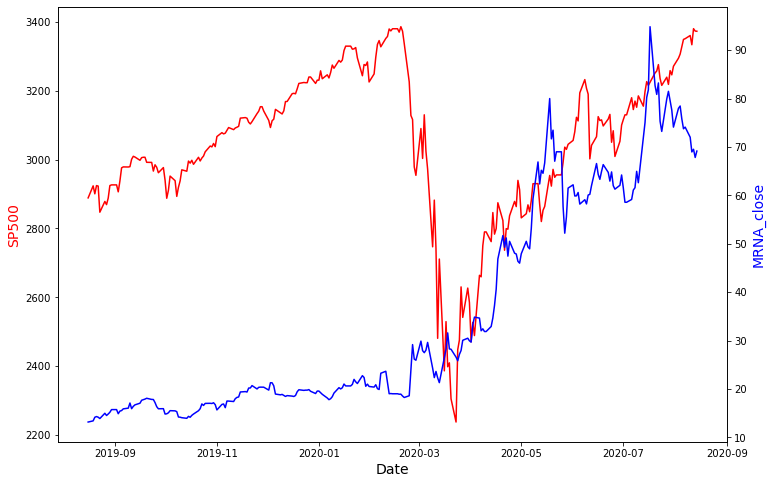

In [8]:
#df[['SP500_close','MRNA_close']].plot(figsize=(12,8))
# title='Closing Prices for SP500 and MRNA'
# ylabel='Closing Price (USD)'
# xlabel='Date'

# ax = df['SP500_close'].plot(figsize=(12,6),title=title,color='red')
# ax.autoscale(axis='x',tight=True)
# ax.set_ylabel("SP500_close",color="red",fontsize=14)

# ax2=ax.twinx()
# ax2.plot(df['MRNA_close'],color="blue")
# ax2.set_ylabel("MRNA_close",color="blue",fontsize=14)



fig,ax = plt.subplots(figsize=(12,8))
# make a plot
ax.plot(df.index, df['SP500_close'], color="red")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("SP500",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df.index, df['MRNA_close'],color="blue")
ax2.set_ylabel("MRNA_close",color="blue",fontsize=14)

Text(0, 0.5, 'MRNA_close')

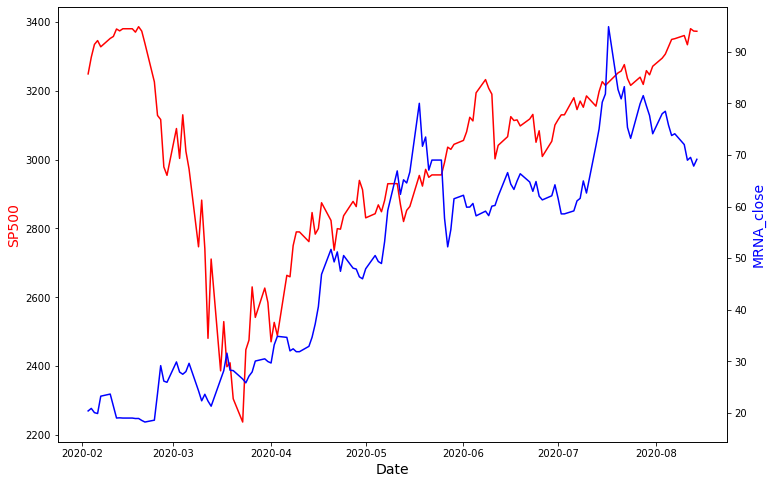

In [6]:
#visualizing the more recent data

from matplotlib import dates
fig,ax = plt.subplots(figsize=(12,8))
# make a plot
ax.plot(df.loc['2020-02-01':,'SP500_close'], color="red")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("SP500",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df.loc['2020-02-01':,'MRNA_close'],color="blue")
ax2.set_ylabel("MRNA_close",color="blue",fontsize=14)




In [7]:
df_copy = df.copy()

In [12]:
df_copy.head()

,MRNA_close,NVAX_close,SP500_close,Dow_close,NASD_close,WMT_close
Date,,,,,,
2019-08-16,13.16,7.84,2888.679932,25886.009766,7895.990234,112.989998
2019-08-19,13.40,7.29,2923.649902,26135.789063,8002.810059,113.809998
2019-08-20,14.15,6.67,2900.510010,25962.439453,7948.560059,112.050003
2019-08-21,14.29,6.83,2924.429932,26202.730469,8020.209961,112.019997
2019-08-22,14.16,6.63,2922.949951,26252.240234,7991.390137,111.910004


In [8]:
df = df.loc['2020-02-01':,:]

In [9]:
df.head(20)

,MRNA_close,NVAX_close,SP500_close,Dow_close,NASD_close,WMT_close
Date,,,,,,
2020-02-03,20.379999,6.81,3248.919922,28399.810547,9273.400391,114.269997
2020-02-04,20.870001,7.01,3297.590088,28807.630859,9467.969727,115.269997
2020-02-05,20.049999,6.97,3334.689941,29290.849609,9508.679688,116.809998
2020-02-06,19.879999,6.84,3345.780029,29379.769531,9572.150391,116.309998
2020-02-07,23.240000,6.31,3327.709961,29102.509766,9520.509766,116.449997
2020-02-10,23.650000,7.02,3352.090088,29276.820313,9628.389648,115.250000
2020-02-11,21.350000,7.21,3357.750000,29276.339844,9638.940430,115.400002
2020-02-12,19.010000,7.31,3379.449951,29551.419922,9725.959961,115.849998
2020-02-13,19.045000,7.79,3373.939941,29423.310547,9711.969727,117.440002


In [10]:
#double check the dataframe index
df.index

DatetimeIndex(['2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-10', '2020-02-11', '2020-02-12',
               '2020-02-13', '2020-02-14',
               ...
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14'],
              dtype='datetime64[ns]', name='Date', length=140, freq='B')

Text(0, 0.5, 'MRNA_close')

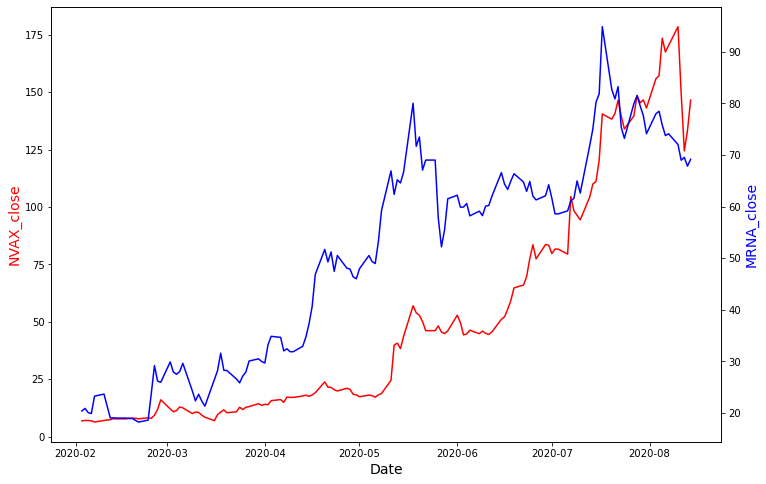

In [11]:
####only visualizing the recent data
from matplotlib import dates

fig,ax = plt.subplots(figsize=(12,8))
# make a plot
ax.plot(df['NVAX_close'], color="red")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("NVAX_close",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['MRNA_close'],color="blue")
ax2.set_ylabel("MRNA_close",color="blue",fontsize=14)

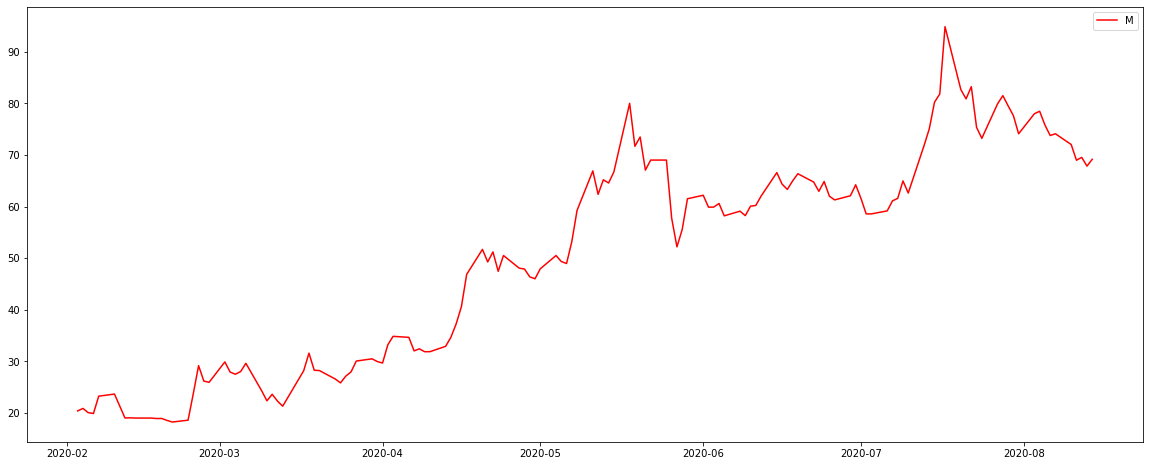

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
MRNAresult = seasonal_decompose(df['MRNA_close'], model='additive')  # model='mul' also works
#MRNAresult.seasonal.plot().autoscale(enable=True,tight=True)
NVAXresult = seasonal_decompose(df['NVAX_close'], model='mul')  # model='mul' also works
#NVAXresult.seasonal.plot().autoscale(enable=True,tight=True)


fig,ax = plt.subplots(figsize=(20,8))
ax.plot(MRNAresult.observed, color="red")
ax.legend('MRNAresult')
# ax2=ax.twinx()
# ax2.plot(NVAXresult.seasonal, color="blue")
# ax2.legend('NVAXresult.seasonal')

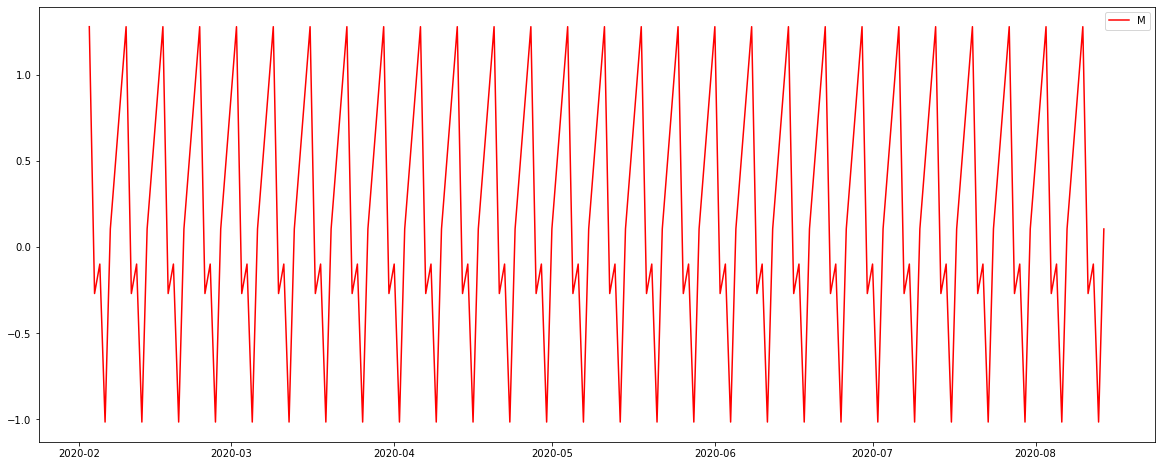

In [29]:
fig,ax = plt.subplots(figsize=(20,8))
ax.plot(MRNAresult.seasonal, color="red")
ax.legend('MRNAresult')

In [30]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs

In [31]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [32]:
adf_test(df['MRNA_close'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.303132
p-value                   0.627738
# lags used               0.000000
# observations          139.000000
critical value (1%)      -3.478294
critical value (5%)      -2.882568
critical value (10%)     -2.577983
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
